In [183]:
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

In [184]:
df = pd.read_csv('../../data/day_ahead_energy_prices.csv', delimiter=",")[::-1]
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.rename(columns={"hourly day-ahead energy price": "Price"}, inplace=True)

In [185]:
TEST_SIZE = 0.18

SPLIT_DATE_EVAL = df.index[int(TEST_SIZE * len(df))]


train = df.loc[df.index < SPLIT_DATE_EVAL]
initial_test = df.loc[df.index >= SPLIT_DATE_EVAL]


test_eval_split = int(len(initial_test) / 2)

SPLIT_DATE_TEST = df.index[int(TEST_SIZE * len(df)) - test_eval_split - 1]

test = initial_test.iloc[:test_eval_split]
eval = initial_test.iloc[test_eval_split:]

eval

,Price
Datetime,
2024-05-04 00:00:00,90.80
2024-05-03 23:00:00,85.56
2024-05-03 22:00:00,93.46
2024-05-03 21:00:00,107.95
2024-05-03 20:00:00,119.94
...,...
2023-10-15 05:00:00,7.63
2023-10-15 04:00:00,5.72
2023-10-15 03:00:00,9.06


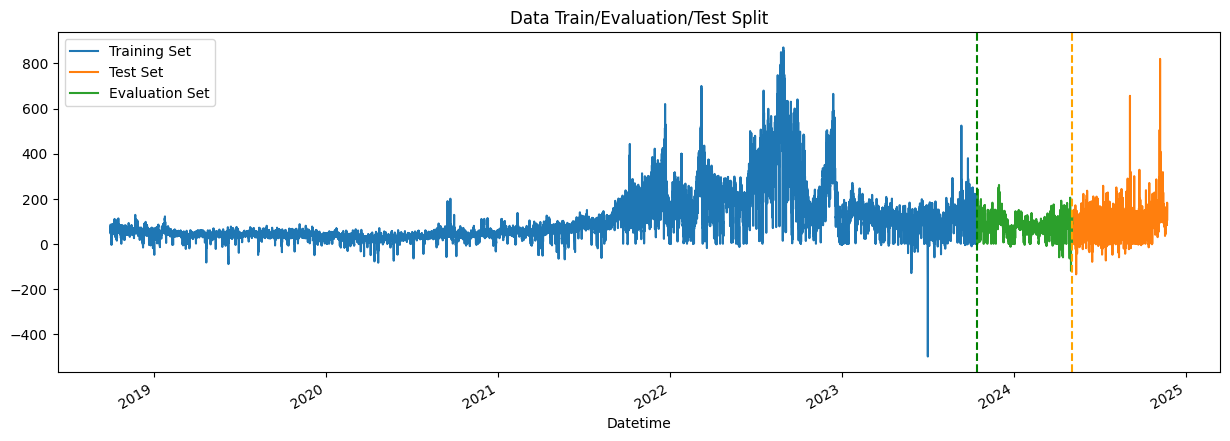

In [186]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Evaluation/Test Split')
test.plot(ax=ax, label='Test Set')
eval.plot(ax=ax, label='Evaluation Set')
ax.axvline(SPLIT_DATE_EVAL, color='green', ls='--')
ax.axvline(SPLIT_DATE_TEST, color='orange', ls='--')
ax.legend(['Training Set', 'Test Set', 'Evaluation Set'])
plt.show()

In [187]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    for window in [3, 6, 12]: # hours
        df[f'ma_{int(window)}_hours'] = df['Price'].rolling(window=window).mean()
    
    for window in [24, 72, 168]:  # 1 day 3 days, and 1 week
        df[f'ma_{int(window / 24)}_days'] = df['Price'].rolling(window=window).mean()

    return df

df = create_features(df)
df

,Price,hour,dayofweek,dayofyear,weekofyear,ma_3_hours,ma_6_hours,ma_12_hours,ma_1_days,ma_3_days,ma_7_days
Datetime,,,,,,,,,,,
2024-11-21 23:00:00,107.46,23,3,326,47,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-21 22:00:00,122.90,22,3,326,47,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-21 21:00:00,123.05,21,3,326,47,117.803333,NaN,NaN,NaN,NaN,NaN
2024-11-21 20:00:00,131.33,20,3,326,47,125.760000,NaN,NaN,NaN,NaN,NaN
2024-11-21 19:00:00,154.05,19,3,326,47,136.143333,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01 04:00:00,47.59,4,0,274,40,56.110000,68.363333,65.673333,59.686667,40.311806,51.385298
2018-10-01 03:00:00,47.38,3,0,274,40,48.860000,63.000000,65.205000,59.837083,40.318750,51.385655
2018-10-01 02:00:00,51.41,2,0,274,40,48.793333,57.406667,64.807500,60.143333,40.399444,51.393095


In [188]:
train = create_features(train)
test = create_features(test)
eval = create_features(eval)

FEATURES = [
    "hour",
    "dayofyear",
    "dayofweek",
    "ma_3_hours",
    "ma_6_hours",
    "ma_1_days",
    "ma_3_days",
    "ma_7_days",
]
TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

best_params = {
    "base_score": np.float64(0.6880643012958115),
    "colsample_bytree": np.float64(0.7165197355751676),
    "early_stopping_rounds": np.int64(2),
    "gamma": np.float64(0.999533123117512),
    "learning_rate": np.float64(1.1424316371261474),
    "max_depth": np.int64(6),
    "min_child_weight": np.int64(2),
    "n_estimators": np.int64(5),
    "subsample": np.float64(0.8336842294498906),
}

reg = xgb.XGBRegressor(
    base_score=best_params["base_score"],
    colsample_bytree=best_params["colsample_bytree"],
    early_stopping_rounds=best_params["early_stopping_rounds"],
    gamma=best_params["gamma"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    min_child_weight=best_params["min_child_weight"],
    n_estimators=best_params["n_estimators"],
    subsample=best_params["subsample"],
    objective="reg:squarederror",
)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=25)

[0]	validation_0-rmse:32.50039	validation_1-rmse:22.52005
[4]	validation_0-rmse:16.99957	validation_1-rmse:16.90240


XGBRegressor(base_score=np.float64(0.6880643012958115), booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.7165197355751676), device=None,
             early_stopping_rounds=np.int64(2), enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.999533123117512), grow_policy=None,
             importance_typ...n_constraints=None,
             learning_rate=np.float64(1.1424316371261474), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=np.int64(6), max_leaves=None,
             min_child_weight=np.int64(2), missing=nan,
             monotone_constraints=None, multi_strategy=None,
             n_estimators=np.int64(5), n_jobs=None, num_parallel_tree=None,
             random_state=None, ...)

In [189]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")

with open(f"./pickle/benchmark_model_dump_{ts}.pickle", "wb") as file:
    pickle.dump(reg, file)

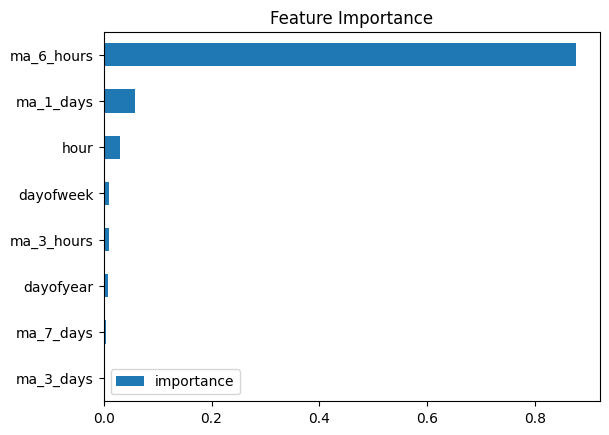

In [190]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [191]:
test['prediction'] = reg.predict(X_test)
test

,Price,hour,dayofweek,dayofyear,weekofyear,ma_3_hours,ma_6_hours,ma_12_hours,ma_1_days,ma_3_days,ma_7_days,prediction
Datetime,,,,,,,,,,,,
2024-11-21 23:00:00,107.46,23,3,326,47,NaN,NaN,NaN,NaN,NaN,NaN,87.976357
2024-11-21 22:00:00,122.90,22,3,326,47,NaN,NaN,NaN,NaN,NaN,NaN,87.976357
2024-11-21 21:00:00,123.05,21,3,326,47,117.803333,NaN,NaN,NaN,NaN,NaN,69.878983
2024-11-21 20:00:00,131.33,20,3,326,47,125.760000,NaN,NaN,NaN,NaN,NaN,69.878983
2024-11-21 19:00:00,154.05,19,3,326,47,136.143333,NaN,NaN,NaN,NaN,NaN,69.878983
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-04 05:00:00,98.34,5,5,125,18,94.183333,77.430000,53.184167,73.936250,73.535139,77.984583,69.591827
2024-05-04 04:00:00,90.64,4,5,125,18,94.390000,85.675000,55.435833,74.598750,73.681806,77.988929,78.432304
2024-05-04 03:00:00,87.72,3,5,125,18,92.233333,89.898333,60.576667,74.900000,73.789167,77.980774,92.533012


In [192]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [193]:
#test error fot the entire test set
score = root_mean_squared_error(test[TARGET], test['prediction'])
print(f'RMSE Score on Test set: {score:.2f}')

RMSE Score on Test set: 24.72


In [194]:
# days and (absolute) error realtion
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean()

date
2024-05-04    16.427623
2024-05-05    14.407976
2024-05-06     8.571155
2024-05-07     7.663691
2024-05-08     7.811511
                ...    
2024-11-17    20.350575
2024-11-18    18.008632
2024-11-19    18.044915
2024-11-20    16.683653
2024-11-21    28.602001
Name: error, Length: 202, dtype: float64

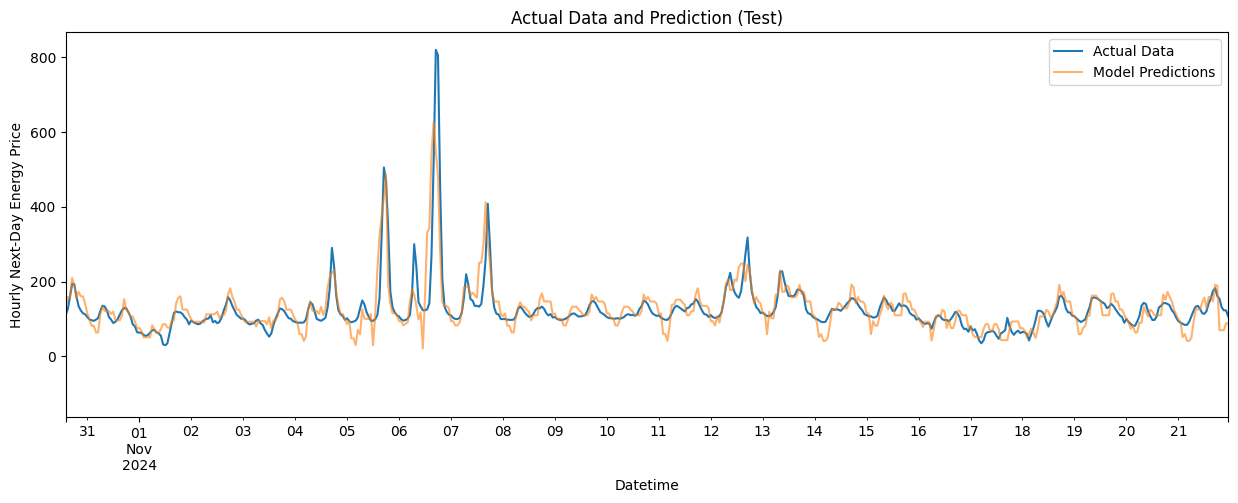

In [195]:

WINDOW = df.iloc[:int(0.01 * (len(df)))].copy()

ax = WINDOW[[TARGET]].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='-', alpha=0.6)
ax.set_xlim(WINDOW.index.min(), WINDOW.index.max())
ax.set_ylabel("Hourly Next-Day Energy Price")
plt.legend(['Actual Data', 'Model Predictions'])    
ax.set_title('Actual Data and Prediction (Test)')
plt.show()

In [196]:
date = '2024-10-29'
predictions = df.loc[date, 'prediction']

# Display the result
print(predictions)

Datetime
2024-10-29 23:00:00     98.737885
2024-10-29 22:00:00    147.277847
2024-10-29 21:00:00    147.277847
2024-10-29 20:00:00    159.162079
2024-10-29 19:00:00    157.253845
2024-10-29 18:00:00    198.960754
2024-10-29 17:00:00    244.143951
2024-10-29 16:00:00    199.252914
2024-10-29 15:00:00    199.252914
2024-10-29 14:00:00    170.128738
2024-10-29 13:00:00    113.490746
2024-10-29 12:00:00    144.550812
2024-10-29 11:00:00    137.711517
2024-10-29 10:00:00    140.327286
2024-10-29 09:00:00    121.502655
2024-10-29 08:00:00    147.041840
2024-10-29 07:00:00    151.133423
2024-10-29 06:00:00    151.133423
2024-10-29 05:00:00     81.995728
2024-10-29 04:00:00     81.995728
2024-10-29 03:00:00     93.896622
2024-10-29 02:00:00     59.340919
2024-10-29 01:00:00    114.712395
2024-10-29 00:00:00    114.712395
Name: prediction, dtype: float32


save models pickel
add 500 to axis -> z-standardisation might also work
features?
register

